# Robot de Almacén

### Datos a considerar
- La semilla para generación de números aleatorios será 67890.
- El almacén es 20x20 celdas.
- Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
- Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
- La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.


### Resultados
-	Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
-	Una visualización que permita ver los diferentes pasos de la simulación.
-	El número de pasos necesarios para terminar la simulación.
-	¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?


### Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [85]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import random


In [86]:
class RobotAgent(Agent):
    """
    Clase que define el comportamiento de un robot en el modelo.
    """
    def __init__(self, id, model):
        super().__init__(id, model)
        self.id = id
        self.has_box = False
        self.active = True
        self.target = None
        self.found_boxes = np.zeros((model.grid.width, model.grid.height), dtype=int)

    def step(self):
        """
        Función que ejecuta el comportamiento del robot en cada paso de la simulación.
        """

        possible_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center = False)

        # Si el robot tiene una caja y no hay celdas con menos de 5 cajas,
        # deja la caja en una celda vacía cuando las pilas de cajas estén casi completas.
        if self.has_box and len(self.find_uncompleted_stacks()) == 0 and np.count_nonzero(self.found_boxes == 5) > 39:
            self.drop_box(possible_cells)
            if(self.id != 0):
                self.active = False # Desactiva el robot para que no siga moviéndose.

        if self.active:
            # Si el robot tiene una caja y no tiene una celda objetivo, selecciona una.
            if self.has_box and self.target == None:
                self.select_target()

            # Si el robot tiene una caja y tiene una celda objetivo, se mueve a la celda objetivo.
            if self.target and self.has_box:
                self.move_to_target()

            # Si el robot no tiene una celda objetivo, analiza su entorno y se mueve a una celda aleatoria.
            if not self.target:
                self.analyze(possible_cells)
                self.move(possible_cells)

    def move(self, possible_cells):
        """
        Función que mueve al robot a una celda aleatoria evitando las celdas con agentes y cajas
        """
        empty_cells = [cell for cell in possible_cells if self.model.boxes[cell] == 0 and not self.has_cellmate(cell)]

        if empty_cells:
            new_position = random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)
            self.pos = new_position
        else:
            self.drop_box(possible_cells)

    def analyze(self, possible_cells):
        """
        Función que busca cajas en las celdas vecinas y las recoge o deja
        según el número de cajas que haya en la celda.
        """
        for cell in possible_cells:
            if self.model.boxes[cell] > 0 and self.target == None:
                self.found_boxes[cell] = self.model.boxes[cell]
                if self.has_box and self.model.boxes[cell] < 5:
                    self.stack_box(cell)
                elif not self.has_box and self.model.boxes[cell] < 3:
                    self.pick_box(cell)
                    self.select_target()

    def pick_box(self, cell):
        """
        Función que recoge una caja de una celda y actualiza los valores de
        las cajas en el modelo.
        """
        self.has_box = True
        self.model.boxes[cell] -= 1
        self.found_boxes[cell] -= 1

    def stack_box(self, cell):
        """
        Función que deja una caja en una celda y actualiza los valores de las cajas en el modelo.
        """
        self.has_box = False
        self.model.boxes[cell] += 1
        self.found_boxes[cell] += 1

    def drop_box(self, possible_cells):
        """
        Función que deja una caja en una celda vacía y actualiza los valores de las cajas en el modelo.
        """
        for cell in possible_cells:
            cellmate = self.has_cellmate(cell)
            if self.model.boxes[cell] == 0 and not cellmate:
                self.stack_box(cell)
                self.target = None
                return

    def find_uncompleted_stacks(self):
        """
        Función que calcula el número de cajas que el robot ha recogido.

        Returns:
            uncompleted_stacks: Lista de celdas que tienen menos de 5 cajas.
        """
        uncompleted_stacks = []
        for x in range(self.model.grid.width):
            for y in range(self.model.grid.height):
                if self.found_boxes[x][y] < 5 and self.found_boxes[x][y] > 2:
                    uncompleted_stacks.append((x,y))
        return uncompleted_stacks

    def move_to_target(self):
        """
        Función que mueve al robot a la celda objetivo un paso más cerca por cada paso de la simulación.
        Si el robot tiene una celda objetivo y está en una celda vecina, deja la caja en la celda objetivo siempre que
        la celda objetivo no tenga 5 cajas.
        """
        neighbor_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center = False)

        if self.target in neighbor_cells:
            if self.model.boxes[self.target] < 5:
                self.stack_box(self.target)
                self.target = None
            else:
                self.target = None
                self.select_target()
            return

        # Obtener la celda más cercana a la celda objetivo.
        new_position = ()
        if self.pos[0] < self.target[0]:
            new_position = (self.pos[0] + 1, self.pos[1])
            if self.has_cellmate(new_position):
                return
        elif self.pos[0] > self.target[0]:
            new_position = (self.pos[0] - 1, self.pos[1])
            if self.has_cellmate(new_position):
                return
        elif self.pos[1] < self.target[1]:
            new_position = (self.pos[0], self.pos[1] + 1)
            if self.has_cellmate(new_position):
                return
        elif self.pos[1] > self.target[1]:
            new_position = (self.pos[0], self.pos[1] - 1)
            if self.has_cellmate(new_position):
                return

        self.model.grid.move_agent(self, new_position)
        self.pos = new_position

    def has_cellmate(self, cell):
        """
        Función que verifica si una celda tiene un agente.

        Returns:
            True si la celda tiene un agente.
            False si la celda no tiene un agente.
        """
        cellmate = self.model.grid.get_cell_list_contents([cell])
        return len(cellmate) > 0

    def select_target(self):
        """
        Función que selecciona una celda objetivo de las celdas que tienen menos de 5 cajas.
        """
        self.target = None
        us = self.find_uncompleted_stacks()

        if len(us) > 1 and self.has_box:
            self.target = random.choice(us)

In [87]:
def get_robots(model):
    """
    Función que obtiene la posición de cada robot en el modelo.

    Returns:
        posiciones de los robots.
    """
    return np.asarray([agent.pos for agent in model.schedule.agents])

In [88]:
def get_boxes(model):
    """
    Función que obtiene la posición de cada caja en el modelo.

    Returns:
        posiciones de las cajas.
    """
    return model.boxes

In [89]:
class WarehouseModel(Model):
    """
    Clase que define el modelo de la simulación.
    """

    def __init__(self, width, height, num_agents, num_boxes):
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, torus=False)
        self.boxes = np.zeros((width, height), dtype=int)
        self.datacollector = DataCollector(model_reporters={"Robot": get_robots, "Boxes": get_boxes})
        self.running = True

        # Inicializa las cajas en posiciones aleatorias.
        init_boxes = 0
        while init_boxes < num_boxes:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if self.boxes[x, y] < 3:
              self.boxes[x, y] += 1
              init_boxes += 1

        # Inicializa los robots en posiciones aleatorias.
        agent_pos = []
        while len(agent_pos) < num_agents:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if (x, y) not in agent_pos and self.boxes[x, y] == 0:
                agent = RobotAgent(len(agent_pos), self)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x, y))
                agent_pos.append((x, y))

        print(f"\nInitial total boxes: {sum(sum(self.boxes))}\n")

    def step(self):
        """
        Función que ejecuta el comportamiento de cada robot en cada paso de la simulación.
        """
        if self.running == False:
             return

        self.datacollector.collect(self)
        self.schedule.step()

In [90]:
# Parámetros de la simulación.

WIDTH = 20
HEIGHT = 20
ROBOTS = 5
ITERATIONS = 10000
MAX_BOXES = 200
SEED = 67890
random.seed(SEED)

In [91]:
# Simulación.

model = WarehouseModel(WIDTH, HEIGHT, ROBOTS, MAX_BOXES)
steps = 0
while (model.running):
    model.step()
    stacks = np.count_nonzero(model.boxes == 5)
    steps += 1
    if(stacks == 40 or steps == ITERATIONS):
        break

print(f"Total steps: {steps}")
print(f"Total stacked boxes: {sum(sum(model.boxes))}")
print(f"Total completed stacks: {np.count_nonzero(model.boxes == 5)}")


Initial total boxes: 200

Total steps: 2176
Total stacked boxes: 200
Total completed stacks: 40


In [92]:
all_positions = model.datacollector.get_model_vars_dataframe()

C:\Users\sgarn\AppData\Local\Temp\ipykernel_26260\2148707644.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
C:\Users\sgarn\AppData\Local\Temp\ipykernel_26260\2148707644.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])


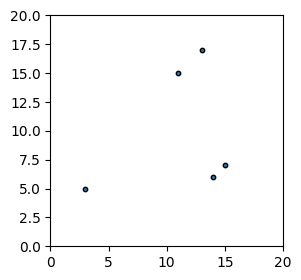

In [93]:
# Animación de la simulación.

fig, ax = plt.subplots(figsize=(3, 3))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = ITERATIONS)

In [94]:
# anim

C:\Users\sgarn\AppData\Local\Temp\ipykernel_26260\536203090.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  box_positions = all_positions.iloc[0][1]


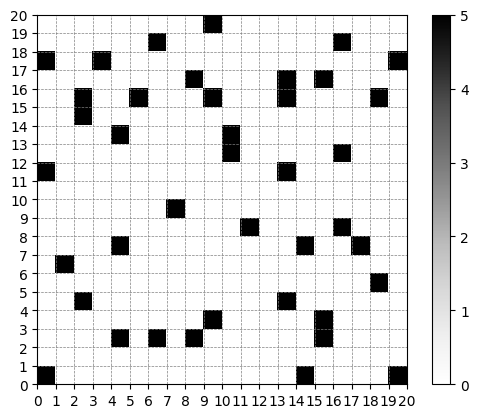

In [95]:
# Gráfica de la distribución de las cajas en el almacén.

box_positions = all_positions.iloc[0][1]
box_counts = np.zeros((WIDTH, HEIGHT), dtype=int)
for x in range(model.grid.width):
    for y in range(model.grid.height):
      box_counts[y][x] = box_positions[x][y]

cmap = plt.cm.Greys

plt.imshow(box_counts, cmap=cmap, interpolation='nearest', origin="lower", extent=[0, HEIGHT, 0, WIDTH])
plt.colorbar()

# Set ticks for both axes
plt.xticks(np.arange(0, HEIGHT+1, 1))
plt.yticks(np.arange(0, WIDTH+1, 1))

# Add grid lines
plt.grid(color='gray', linestyle='--', linewidth=0.5)